## Sound Classification using CNN


### Setup

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/Capston/')
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
import glob
import numpy as np
#import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm
from random import shuffle
from DDUtil import *

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers

from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [5]:
class_name = np.array(['0_water', '1_meal', '2_toilet', '3_noise'])
n_classes = class_name.shape[0]

In [6]:
from ml_util import load_dataset2

In [7]:
data_root='/content/drive/My Drive/Colab Notebooks/Capston/data'

In [8]:
vclass, vidxs =load_dataset2(folderfmt=data_root+'/*_small/')

['/content/drive/My Drive/Colab Notebooks/Capston/data/0_small/'
 '/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/'
 '/content/drive/My Drive/Colab Notebooks/Capston/data/2_small/'
 '/content/drive/My Drive/Colab Notebooks/Capston/data/3_small/']


In [9]:
print(np.shape(vclass))
print(np.shape(vclass[0]))
print(vclass[1][0:5])

(4,)
(3033,)
['/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/meal1.png', '/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/meal10.png', '/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/meal100.png', '/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/meal101.png', '/content/drive/My Drive/Colab Notebooks/Capston/data/1_small/meal102.png']


In [10]:
print(np.shape(vidxs))
print(np.shape(vidxs[0]))
print(vidxs[1][:5])

(4,)
(3033,)
[1 1 1 1 1]


### Dataframe으로 변환

In [11]:
data = []
for i in range(len(vidxs)):
    for j in range(len(vidxs[i])):
        cl1 = '{}'.format(vidxs[i][j])
        fn1 = vclass[i][j]
        #print(i, j,fn1 , cl1)
        data1 = [fn1, cl1]
        data.append(data1) 

In [12]:
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['ID', 'Class']) 

In [13]:
df

,ID,Class
0,/content/drive/My Drive/Colab Notebooks/Capsto...,0
1,/content/drive/My Drive/Colab Notebooks/Capsto...,0
2,/content/drive/My Drive/Colab Notebooks/Capsto...,0
3,/content/drive/My Drive/Colab Notebooks/Capsto...,0
4,/content/drive/My Drive/Colab Notebooks/Capsto...,0
...,...,...
7043,/content/drive/My Drive/Colab Notebooks/Capsto...,3
7044,/content/drive/My Drive/Colab Notebooks/Capsto...,3
7045,/content/drive/My Drive/Colab Notebooks/Capsto...,3
7046,/content/drive/My Drive/Colab Notebooks/Capsto...,3



### Split training and test sets

In [14]:
df_copy = df.copy()
do_split = False
if do_split:
    traindf = df_copy.sample(frac=0.75, random_state=0)
    testdf = df_copy.drop(traindf.index)
else: # split will be done in ImageDataGenerator function
    # https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
    print('Data split will be done in ImageDataGenerator function')
    traindf = df.sample(frac=1).reset_index(drop=True)

Data split will be done in ImageDataGenerator function


In [15]:
traindf

,ID,Class
0,/content/drive/My Drive/Colab Notebooks/Capsto...,2
1,/content/drive/My Drive/Colab Notebooks/Capsto...,1
2,/content/drive/My Drive/Colab Notebooks/Capsto...,1
3,/content/drive/My Drive/Colab Notebooks/Capsto...,1
4,/content/drive/My Drive/Colab Notebooks/Capsto...,1
...,...,...
7043,/content/drive/My Drive/Colab Notebooks/Capsto...,0
7044,/content/drive/My Drive/Colab Notebooks/Capsto...,0
7045,/content/drive/My Drive/Colab Notebooks/Capsto...,1
7046,/content/drive/My Drive/Colab Notebooks/Capsto...,2


In [16]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [17]:
directory = './' #base_dir_out+'_train'
print(directory)
train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=directory,
    x_col="ID",
    y_col="Class",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

./
Found 5286 validated image filenames belonging to 4 classes.


In [18]:
#directory = base_dir_out+'_train'
directory = './' 
print(directory)
valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=directory,#directory="/kaggle/working/train/",
    x_col="ID",
    y_col="Class",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

./
Found 1762 validated image filenames belonging to 4 classes.


In [19]:
print(train_generator.n)
print(train_generator.batch_size)

5286
32


In [20]:
print(valid_generator.n)
print(valid_generator.batch_size)

1762
32


In [21]:
train_generator.n+valid_generator.n

7048

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',  input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(n_classes, activation='softmax'))

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',  input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(n_classes, activation='softmax'))

In [23]:
model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)       

In [24]:
model_name = 'cnn1'

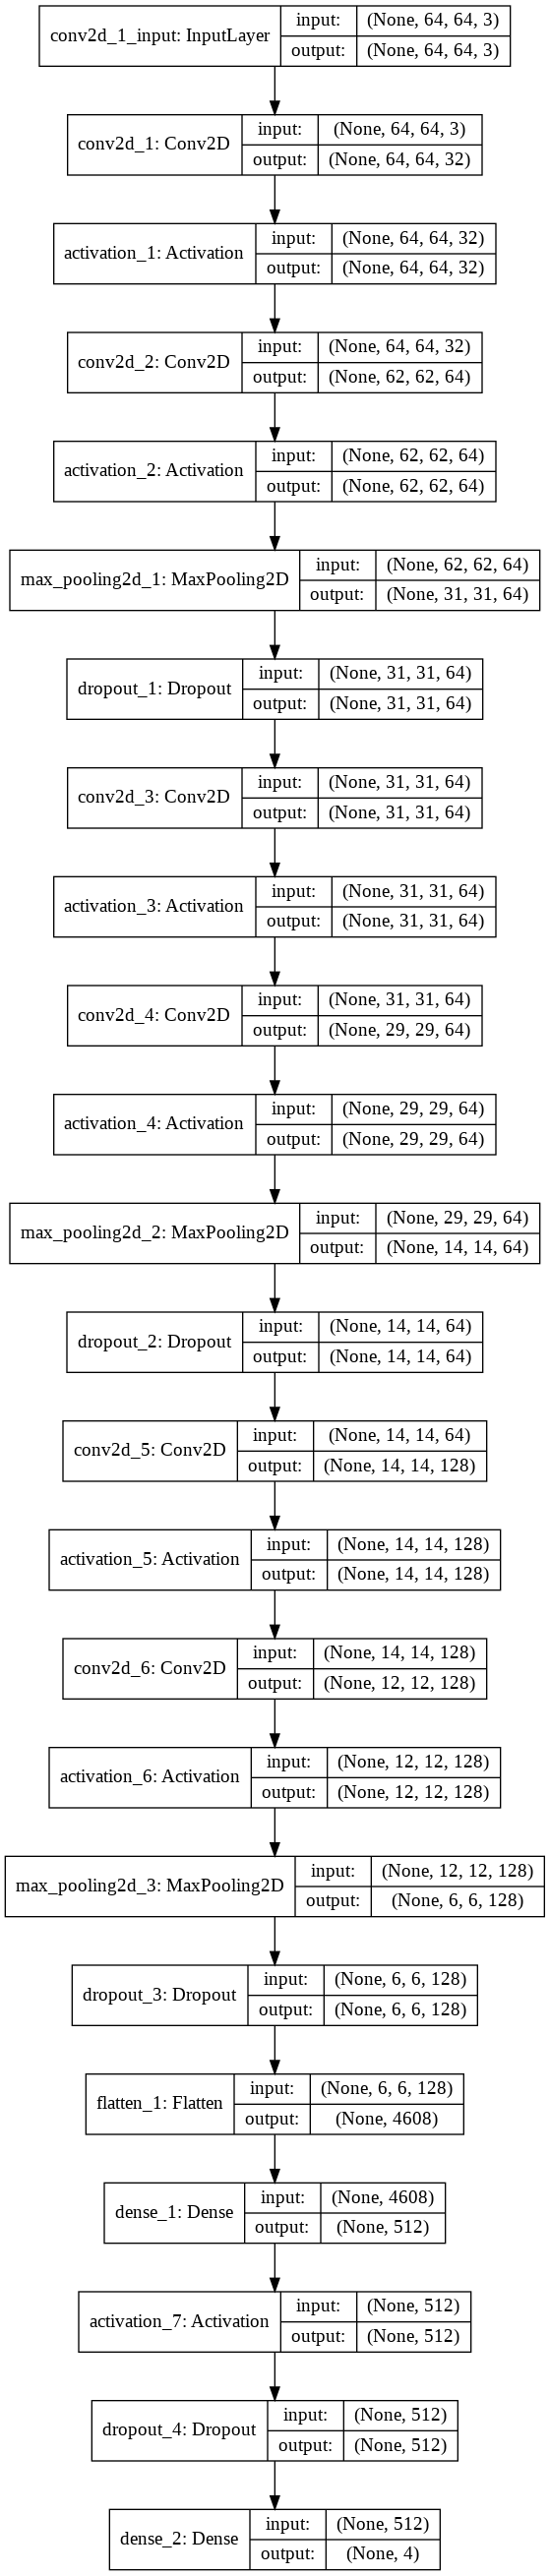

In [25]:
from keras.utils import plot_model
outDir = './'
plot_model(model, to_file='{}/model_{}.png'.format(outDir, model_name), show_shapes=True)
from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, model_name))

In [26]:
#Fitting keras model, no test gen for now
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_VALID=int(np.ceil(valid_generator.n/valid_generator.batch_size))

print('STEP_SIZE_TRAIN={}'.format(STEP_SIZE_TRAIN))
print('STEP_SIZE_VALID={}'.format(STEP_SIZE_VALID))

STEP_SIZE_TRAIN=165
STEP_SIZE_VALID=56


### 모델 불러오기

In [27]:
base_dir_out = '/content/drive/My Drive/Colab Notebooks/Capston/data'
outDir = '{}/cnn_CL{}'.format(base_dir_out, n_classes)
fnmodel=outDir+'/model4.h5'
print(fnmodel)

/content/drive/My Drive/Colab Notebooks/Capston/data/cnn_CL4/model4.h5


In [28]:
%%time
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
to_Train=False
if to_Train:
    hist = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=80)
    
    model.save(fnmodel)
    print('Saved the trained model {}.. okay'.format(fnmodel))
else:
    model = load_model(fnmodel)
    print('Loaed a model {}.. okay'.format(fnmodel))

Loaed a model /content/drive/My Drive/Colab Notebooks/Capston/data/cnn_CL4/model4.h5.. okay
CPU times: user 842 ms, sys: 31.4 ms, total: 873 ms
Wall time: 1.84 s


### 위에서 학습된 모델을 이용하여 평가해보기 

In [29]:
v = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
eval_acc = v[1]
print("acc : ",eval_acc)

acc :  0.9960272312164307


In [30]:
ttl2 = 'CNN, Acc = {:.2f}%'.format(100.0*eval_acc)    

In [31]:
if to_Train:
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots(figsize=(16,10))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')
    plt.title(ttl2)
    plt.show()

### Predict
* 학습이 아니고, 정확도 확인하는 것도 아닌 그냥 inference만 하는 것

In [32]:
pred_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=directory,#directory="/kaggle/working/train/",
    x_col="ID",
    y_col= "Class",#None,
    subset="validation",
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    target_size=(64,64))

Found 1762 validated image filenames belonging to 4 classes.


In [33]:
pred_generator.reset()

In [34]:
v = model.predict_generator(generator=pred_generator, steps=STEP_SIZE_VALID)

In [35]:
v = model.predict_generator(generator=pred_generator, steps=STEP_SIZE_VALID)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
#print(valid_generator.class_indices)
#print(v)
a=0
success=0
fail=0
for i in range(5):
  print("{} -- {}".format(v[i], valid_generator.filenames[i][61:]))
  print("Predict : {} Label : {}".format(np.argmax(v[i]), valid_generator.labels[i]))
  if np.argmax(v[i]) == valid_generator.labels[i]:
    success+=1
  else:
    fail+=1
print("Success to predict {} files".format(success))
print("Fail to predict {} files".format(fail))

[0.000 0.000 1.000 0.000] -- toilet_music168.png
Predict : 2 Label : 2
[0.000 1.000 0.000 0.000] -- meal_aug35.png
Predict : 1 Label : 1
[0.000 1.000 0.000 0.000] -- meal_music815.png
Predict : 1 Label : 1
[0.000 1.000 0.000 0.000] -- meal_music574.png
Predict : 1 Label : 1
[0.000 1.000 0.000 0.000] -- meal_music772.png
Predict : 1 Label : 1
Success to predict 5 files
Fail to predict 0 files


### Confusion matrix 그려보기

In [36]:
print(np.shape(v))
print(v[0])
print(np.argmax(v[0]))

(1762, 4)
[0.000 0.000 1.000 0.000]
2


In [37]:
vpred = np.argmax(v, axis=1)
print(vpred.shape)

(1762,)


In [38]:
expected = pred_generator.classes
expected = np.array(expected)
print(np.shape(expected))

(1762,)


In [39]:
import pandas as pd

conf_matrix = pd.crosstab(expected, vpred) 
print(conf_matrix)

col_0    0    1    2    3
row_0                    
0      763    3    1    0
1        1  602    1    1
2        0    0  285    0
3        0    0    0  105


In [40]:
ttl1 = 'cnn_CL{}'.format(n_classes)
comp_results = [expected, vpred]
fcomp = '{}/{}_comp.txt'.format(outDir, ttl1)
print(fcomp)
np.savetxt(fcomp, comp_results,fmt='%d', delimiter='\t')

/content/drive/My Drive/Colab Notebooks/Capston/data/cnn_CL4/cnn_CL4_comp.txt


In [41]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.utils.multiclass import unique_labels

In [42]:
def plot_confusion_matrix2(actual, predicted, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.viridis):
    
    conf_matrix = confusion_matrix(actual, predicted)
    classes = classes[unique_labels(actual, predicted)]
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] *100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, size=12)
    plt.colorbar(fraction=0.05, pad=0.05)
    tick_marks = np.arange(len(classes), len(classes))
    plt.xticks(np.arange(4), ('0_water', '1_meal', '2_toilet', '3_noise'))
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center", color="white" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
    fig.tight_layout()
    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)
    plt.show()

Normalized confusion matrix


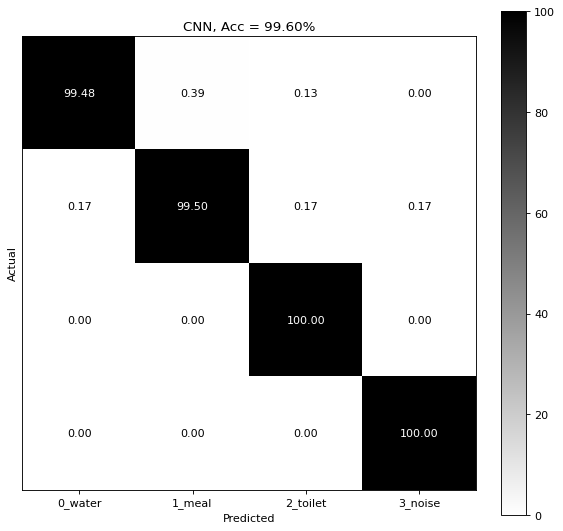

In [43]:
plot_confusion_matrix2(expected, vpred, class_name, title=ttl2, cmap = 'binary' )

In [44]:
from collections import OrderedDict

cmaps = OrderedDict()

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

### Classification Report

In [45]:
from sklearn.metrics import classification_report

In [46]:
print('Classification Report')
print(classification_report(expected, vpred, target_names=class_name))

Classification Report
              precision    recall  f1-score   support

     0_water       1.00      0.99      1.00       767
      1_meal       1.00      1.00      1.00       605
    2_toilet       0.99      1.00      1.00       285
     3_noise       0.99      1.00      1.00       105

    accuracy                           1.00      1762
   macro avg       0.99      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762



### References
[1] Adrian Yijie Xu, Urban Sound Classification using Convolutional Neural Networks with Keras: Theory and Implementation https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4

[2] Different ways to create Pandas Dataframe https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/

[3] Tutorial on Keras flow_from_dataframe
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c